In [1]:
import gym
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.ppo.policies import CnnPolicy
from stable_baselines3.ppo.policies import MlpPolicy
from utils.adversary_env import AdversaryEnv
from utils.cartpole_wrapper import CartPoleWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

# CONST
N_EPISODES = 25

# Load target model
target_model = A2C.load("../a2c/model/lunarlander_v2_a2c_3M_to_11M")

In [2]:
# Test target model - for info on why the env is wrapped with Monitor check the evaluate_policy function
mean_reward, std_reward = evaluate_policy(target_model, Monitor(gym.make('LunarLander-v2')), n_eval_episodes=N_EPISODES)
print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward: 255.81 +/- 59.34


In [3]:
# Create adversary with adversary env
# adversary_env = AdversaryEnv(gym.make('LunarLander-v2'), target_model)
# adversary = PPO(MlpPolicy, adversary_env, verbose=1)

In [4]:
# Train adversary
# log_dir = "./out/training-log/"
# log_path = log_dir + f"adversary-adversary-lunarlander-v2/"
# save_dir = "./models/adversary-lunarlander-v2/"

# timesteps = 50000

# adversary.learn(
#         total_timesteps=timesteps,
#         callback=None,
#         log_interval=-1,
#         eval_env=adversary_env, 
#         eval_freq=5000, 
#         n_eval_episodes=100,
#         tb_log_name='PPO',
#         eval_log_path=log_path, 
#         reset_num_timesteps=False
#         )

# # Save adversary
# adversary.save(save_dir + f"adversary_lunarlander_v2_{timesteps}")

In [5]:
# Load adversary
save_dir = "./models/adversary-lunarlander-v2/"

adversary = PPO.load(save_dir + f"adversary_lunarlander_v2_50000")
adversary_env = AdversaryEnv(gym.make('LunarLander-v2'), target_model)

In [6]:
import numpy as np
import pandas as pd
from strategically_timed_attack import StrategicallyTimedAttack

# Evaluate strategically timed adversarial attack over different beta
data_dict = {
    'beta': [],
    'mean_rew': [],
    'mean_perturbation': [],
    'mean_n_timesteps': [],
    'mean_n_attacks': []
}

for j in range(1, 100):
    beta = j/100

    all_episodes_rewards = []
    all_episodes_perturbation = []
    all_episodes_n_timesteps = []
    all_episodes_n_attacks = []

    for i in range(0, N_EPISODES):
        # Run attack on a2c model
        env = gym.make('LunarLander-v2')
        ua = StrategicallyTimedAttack(env=env, model=target_model, attack=adversary, epsilon=0.25, beta=beta)
        ua.perform_attack()

        all_episodes_rewards.append(ua.reward_total)
        all_episodes_perturbation.append(ua.perturbation_total)
        all_episodes_n_timesteps.append(ua.frames_count)
        all_episodes_n_attacks.append(ua.n_attacks)

        ua.reset_attack()

    data_dict['beta'].append(beta)
    data_dict['mean_rew'].append(np.round(np.mean(all_episodes_rewards), 2))
    data_dict['mean_perturbation'].append(np.round(np.mean(all_episodes_perturbation), 2))
    data_dict['mean_n_timesteps'].append(np.round(np.mean(all_episodes_n_timesteps), 2))
    data_dict['mean_n_attacks'].append(np.round(np.mean(all_episodes_n_attacks), 2))

    print("------------------------------------------")
    print(
        f"{data_dict['beta'][-1] = }: \n" +
        f"{data_dict['mean_rew'][-1] = } \n" +
        f"{data_dict['mean_perturbation'][-1] = } \n" +
        f"{data_dict['mean_n_timesteps'][-1] = } \n" +
        f"{data_dict['mean_n_attacks'][-1] = }"
        )
    print("------------------------------------------")

------------------------------------------
data_dict['beta'][-1] = 0.01: 
data_dict['mean_rew'][-1] = -466.61 
data_dict['mean_perturbation'][-1] = 391.31 
data_dict['mean_n_timesteps'][-1] = 69.56 
data_dict['mean_n_attacks'][-1] = 69.56
------------------------------------------
------------------------------------------
data_dict['beta'][-1] = 0.02: 
data_dict['mean_rew'][-1] = -480.34 
data_dict['mean_perturbation'][-1] = 401.14 
data_dict['mean_n_timesteps'][-1] = 72.84 
data_dict['mean_n_attacks'][-1] = 72.84
------------------------------------------
------------------------------------------
data_dict['beta'][-1] = 0.03: 
data_dict['mean_rew'][-1] = -464.34 
data_dict['mean_perturbation'][-1] = 385.53 
data_dict['mean_n_timesteps'][-1] = 67.36 
data_dict['mean_n_attacks'][-1] = 67.36
------------------------------------------
------------------------------------------
data_dict['beta'][-1] = 0.04: 
data_dict['mean_rew'][-1] = -468.4 
data_dict['mean_perturbation'][-1] = 385.56 

In [7]:
print(data_dict)

{'beta': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99], 'mean_rew': [-466.61, -480.34, -464.34, -468.4, -478.01, -416.77, -495.77, -528.66, -492.03, -424.59, -480.44, -452.64, -469.22, -462.46, -498.27, -415.54, -482.73, -431.56, -466.15, -516.12, -465.11, -458.38, -465.54, -464.71, -491.18, -485.58, -467.89, -496.37, -490.34, -450.54, -506.61, -488.62, -458.71, -455.2, -458.11, -496.67, -454.76, -477.36, -474.37, -420.66, -496.14, -435.88, -499.4, -476.27

In [8]:
# Create DataFrame
data_df = pd.DataFrame(
        data_dict, 
        columns=data_dict.keys(),
        )
data_df.set_index('beta', inplace=True)

# Save data as .csv file
with open("./out/data/" + "strategically_timed_attack_beta", 'w') as f:
    data_df.to_csv(f)

data_df

,mean_rew,mean_perturbation,mean_n_timesteps,mean_n_attacks
beta,,,,
0.01,-466.61,391.31,69.56,69.56
0.02,-480.34,401.14,72.84,72.84
0.03,-464.34,385.53,67.36,67.36
0.04,-468.40,385.56,67.88,67.88
0.05,-478.01,435.42,71.36,71.36
...,...,...,...,...
0.95,-469.71,385.67,71.76,65.00
0.96,-400.18,340.78,75.76,62.72
0.97,-346.00,303.08,72.64,57.64


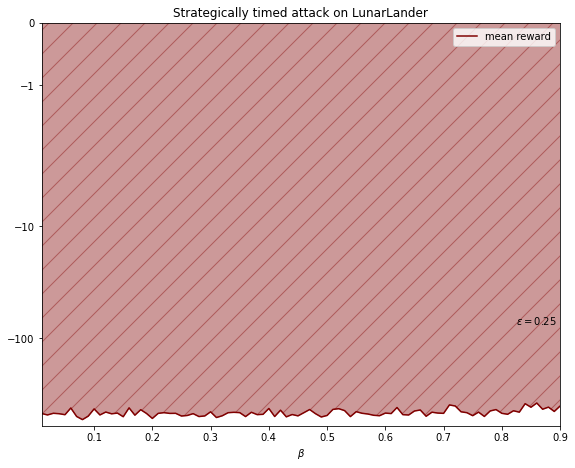

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Load data
with open("./out/data/" + "strategically_timed_attack_beta", 'r') as f:
    data_df = pd.read_csv(f, index_col=0)

# Plot data_df
fig = plt.figure(figsize=(9,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.plot(data_df.index, data_df['mean_rew'], color='maroon', label='mean reward', alpha=1, zorder=0)
plt.fill_between(data_df.index, data_df['mean_rew'], color='maroon', hatch='/', step=None, alpha=0.4)
# plt.vlines(data_df.index, ymin=0, ymax=data_df['mean_rew'], color=np.where(data_df['mean_rew'] < 0, 'maroon', 'darkgreen'), alpha=1, zorder=1)
# plt.scatter(data_df.index, data_df['mean_rew'], color=np.where(data_df['mean_rew'] < 0, 'maroon', 'darkgreen'), label='mean reward', marker='D', alpha=1, zorder=2)

# plt.plot(data_df.index, data_df['mean_perturbation'], label='mean perturbation', color='crimson', linestyle='dotted', alpha=1, zorder=0)

# plt.plot(data_df.index, data_df['mean_n_timesteps'], label='mean n timesteps', color='purple', linestyle='dotted', alpha=1, zorder=0)

# plt.plot(data_df.index, data_df['mean_n_attacks'], label='mean n attacks', color='black', linestyle='dashed', alpha=1, zorder=0)

plt.title("Strategically timed attack on LunarLander")
plt.legend()
plt.xlabel('$\\beta$')
# plt.ylabel()
plt.yscale('symlog')
# plt.axis([0.01, 0.9, -500, 500]) # plt.axis([xmin, xmax, ymin, ymax])
plt.axis([0.01, 0.9, -600, 0.0001])
plt.text(0.825, -75, "$\epsilon = 0.25$")
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.show()

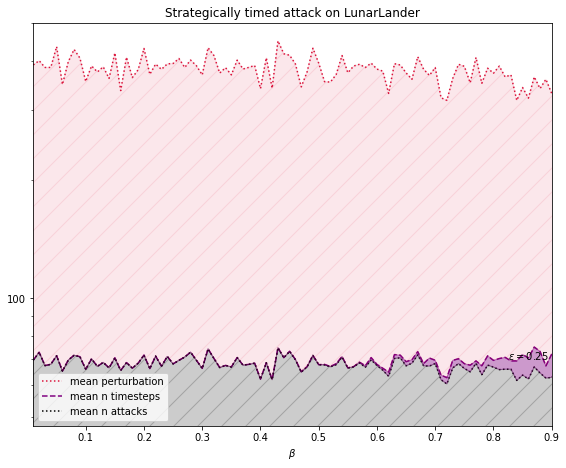

In [10]:
# Plot data_df
fig2 = plt.figure(figsize=(9,7))
ax2 = fig2.add_axes([0.1, 0.1, 0.8, 0.8])
# plt.plot(data_df.index, data_df['mean_rew'], color='darkslategray', alpha=1, zorder=0)
# plt.vlines(data_df.index, ymin=0, ymax=data_df['mean_rew'], color=np.where(data_df['mean_rew'] < 0, 'maroon', 'darkgreen'), alpha=1, zorder=1)
# plt.scatter(data_df.index, data_df['mean_rew'], color=np.where(data_df['mean_rew'] < 0, 'maroon', 'darkgreen'), label='mean reward', marker='D', alpha=1, zorder=2)

plt.plot(data_df.index, data_df['mean_perturbation'], label='mean perturbation', color='crimson', linestyle='dotted', alpha=1, zorder=0)
plt.fill_between(data_df.index, data_df['mean_perturbation'], data_df['mean_n_timesteps'], color='crimson', hatch='/', step=None, alpha=0.1)

plt.plot(data_df.index, data_df['mean_n_timesteps'], label='mean n timesteps', color='purple', linestyle='dashed', alpha=1, zorder=0)
plt.fill_between(data_df.index, data_df['mean_n_timesteps'], data_df['mean_n_attacks'], color='purple', step=None, alpha=0.4)

plt.plot(data_df.index, data_df['mean_n_attacks'], label='mean n attacks', color='black', linestyle='dotted', alpha=1, zorder=0)
plt.fill_between(data_df.index, data_df['mean_n_attacks'], color='black', hatch='/', step=None, alpha=0.2)

plt.title("Strategically timed attack on LunarLander")
plt.legend()
plt.xlabel('$\\beta$')
# plt.ylabel()
plt.yscale('log')
# plt.axis([0.01, 0.9, 0, 250]) # plt.axis([xmin, xmax, ymin, ymax])
plt.xlim([0.01, 0.9])
for axis in [ax2.xaxis, ax2.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.text(0.825, 70, "$\epsilon = 0.25$")
plt.show()